In [20]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

import pandas as pd
from fiesta.plot import corner_plot, LightcurvePlotter
from fiesta.inference.lightcurve_model import BullaFlux
from fiesta.inference.injection import InjectionKN
from fiesta.inference.likelihood import EMLikelihood
from fiesta.utils import load_event_data



## Variable systematic uncertainty

Load the data

In [21]:
with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)
data = load_event_data("./data/injection_Bu2025.dat")
trigger_time = params["trigger_time"]

posterior_fiesta = pd.DataFrame(dict(np.load("./outdir_fiesta/posterior.npz")))


Make corner plot

In [22]:
var_names = ["inclination_EM", "log10_mej_dyn", "v_ej_dyn", "Ye_dyn", "log10_mej_wind", "v_ej_wind", "Ye_wind", "sys_err"]


model = BullaFlux("Bu2025_MLP",
                   filters = data.keys())

likelihood = EMLikelihood(model,
                          data,
                          trigger_time=trigger_time,
                          tmin=0.2,
                          tmax = 26.0,
                          fixed_params={"luminosity_distance": 40.0, "redshift": 0.0},
                          )

lc_plotter = LightcurvePlotter(posterior_fiesta,
                               likelihood,
                               free_syserr=True)

injection = InjectionKN(filters=data.keys(), 
                        N_datapoints=75, 
                        error_budget=0.1, 
                        tmin=0.5, 
                        tmax=25,
                        trigger_time=trigger_time,
                        detection_limit=24
                        )

true_lc = injection._get_injection_lc_from_file(params, "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/KN/training_data/Bu2025_raw_data.h5")

13:11 fiesta INFO    : Loading surrogate Bu2025_MLP. This surrogate should only be used in the following parameter ranges:
INFO:fiesta:Loading surrogate Bu2025_MLP. This surrogate should only be used in the following parameter ranges:
13:11 fiesta INFO    : 	 log10_mej_dyn: (-3.0, -1.3010299956639813)
INFO:fiesta:	 log10_mej_dyn: (-3.0, -1.3010299956639813)
13:11 fiesta INFO    : 	 v_ej_dyn: (0.12, 0.28)
INFO:fiesta:	 v_ej_dyn: (0.12, 0.28)
13:11 fiesta INFO    : 	 Ye_dyn: (0.15, 0.35)
INFO:fiesta:	 Ye_dyn: (0.15, 0.35)
13:11 fiesta INFO    : 	 log10_mej_wind: (-2.0, -0.8860566476931633)
INFO:fiesta:	 log10_mej_wind: (-2.0, -0.8860566476931633)
13:11 fiesta INFO    : 	 v_ej_wind: (0.05, 0.15)
INFO:fiesta:	 v_ej_wind: (0.05, 0.15)
13:11 fiesta INFO    : 	 Ye_wind: (0.2, 0.4)
INFO:fiesta:	 Ye_wind: (0.2, 0.4)
13:11 fiesta INFO    : 	 inclination_EM: (0.0, 1.5707963267948966)
INFO:fiesta:	 inclination_EM: (0.0, 1.5707963267948966)
13:11 fiesta INFO    : Surrogate Bu2025_MLP is loading wit

Found suitable injection with {'inclination_EM': 0.45102681179626236, 'log10_mej_dyn': -1.7212463990471711, 'v_ej_dyn': 0.17, 'Ye_dyn': 0.18, 'log10_mej_wind': -1.3979400086720375, 'v_ej_wind': 0.07, 'Ye_wind': 0.29, 'luminosity_distance': 40.0, 'redshift': 0.0, 'trigger_time': 58849}


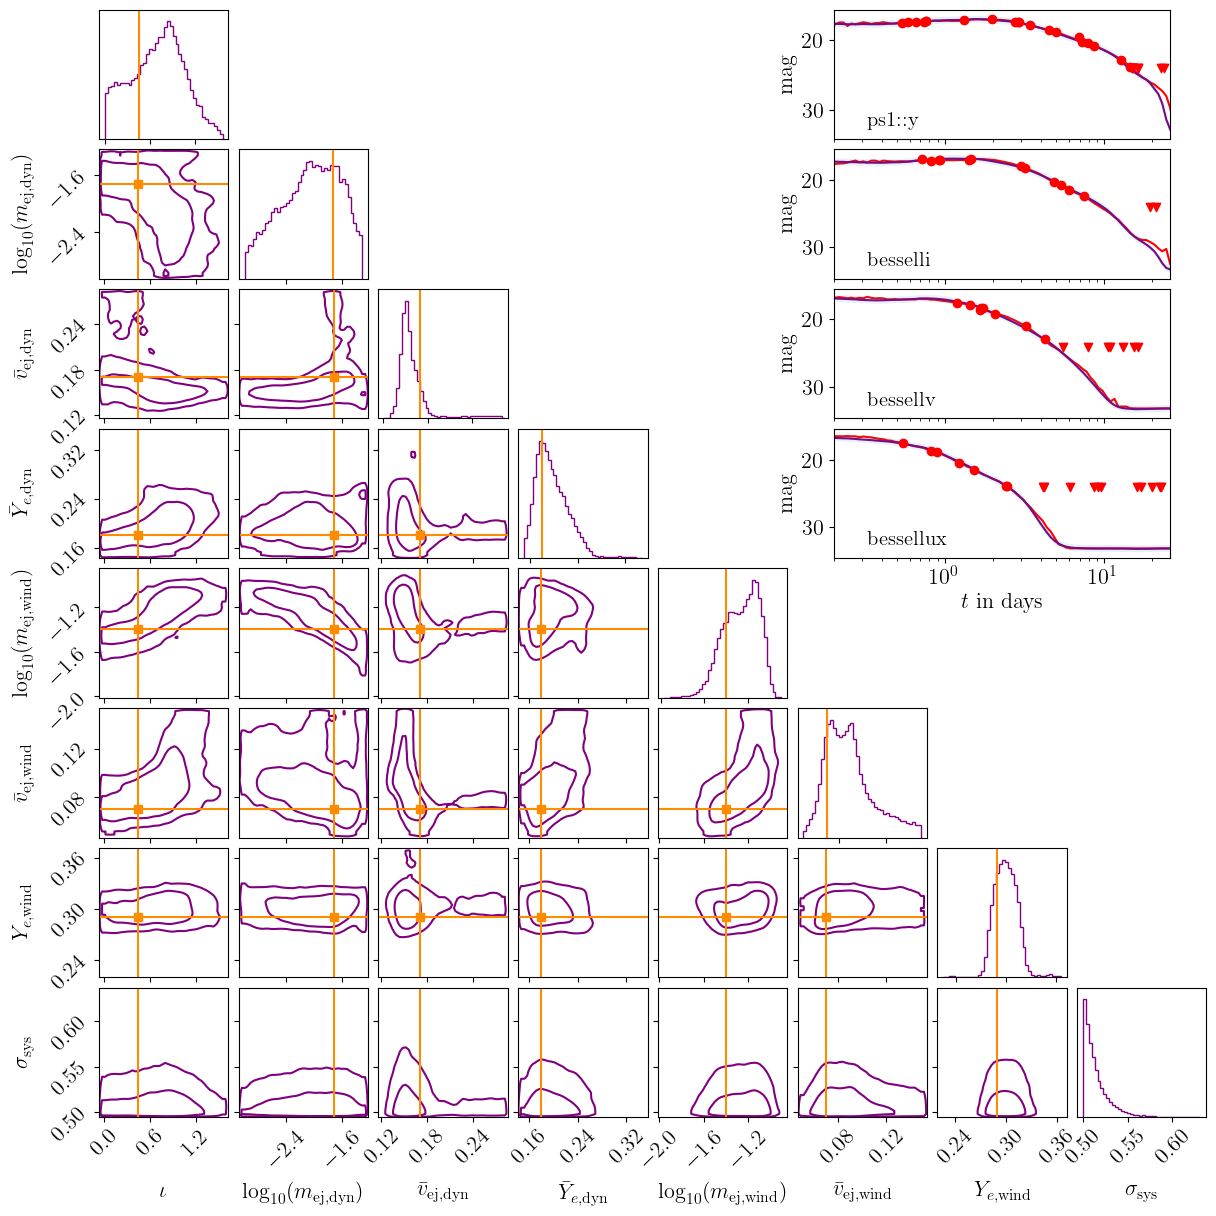

In [26]:
fig, ax = corner_plot(posterior_fiesta, parameter_names=var_names, truths=params, color="purple")
fig.subplots_adjust(wspace=0.08, hspace=0.08)

def plot_lcs(j, filt):

    for k in range(5, 8):
        fig.delaxes(ax[j, k])

    pos1 = ax[j, 5].get_position()
    pos2 = ax[j, 7].get_position()

    x0 = pos1.x0+0.03
    y0 = pos1.y0
    width = pos2.x1 - x0
    height = pos1.height  # same height as original row

    ax_merged = fig.add_axes([x0, y0, width-0.03, height])

    ax_merged.plot(true_lc[0], true_lc[1][filt], color="red")
    lc_plotter.plot_data(ax_merged, filt, color="red")
    lc_plotter.plot_best_fit_lc(ax_merged, filt, color="purple")
    lc_plotter.plot_sys_uncertainty_band(ax_merged, filt)

    ax_merged.set_xscale("log")
    ax_merged.set_xlim(0.2, 26.)

    ax_merged.invert_yaxis()
    ax_merged.set_ylabel("mag")
    ax_merged.text(0.1, 0.1, filt, transform=ax_merged.transAxes, fontsize=15)
    
    if j!=3:
        ax_merged.set_xticklabels([])

    if j==3:
        ax_merged.set_xlabel("$t$ in days")



plot_lcs(0, "ps1::y")
plot_lcs(1, "besselli")
plot_lcs(2, "bessellv")
plot_lcs(3, "bessellux")

fig.savefig("./figures/injection_Bu2025.pdf", dpi=250, bbox_inches="tight")

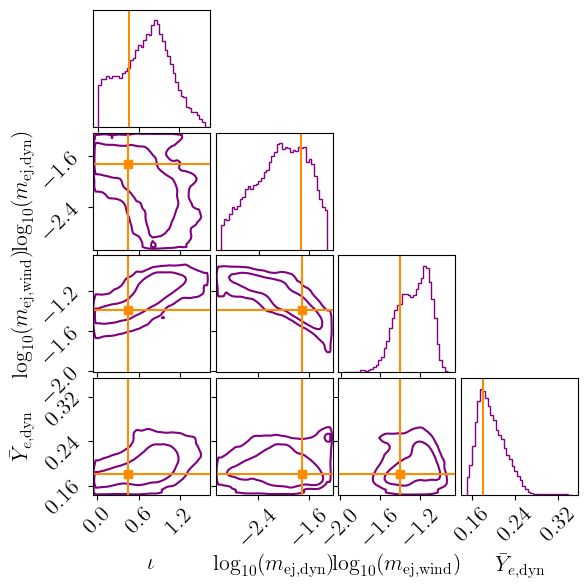

In [24]:
fig, ax = corner_plot(posterior_fiesta, parameter_names=["inclination_EM", "log10_mej_dyn", "log10_mej_wind", "Ye_dyn"], truths=params, color="purple")

handles = []
for c in ["purple"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

#for cax in ax.flatten():
#    cax.xaxis.label.set_fontsize(15)
#    cax.yaxis.label.set_fontsize(15)
#    cax.tick_params(labelsize=12)

fig.subplots_adjust(bottom=0.15, left=0.15)
#fig.savefig("./figures/injection_Bu2025.pdf", dpi=250, bbox_inches="tight")

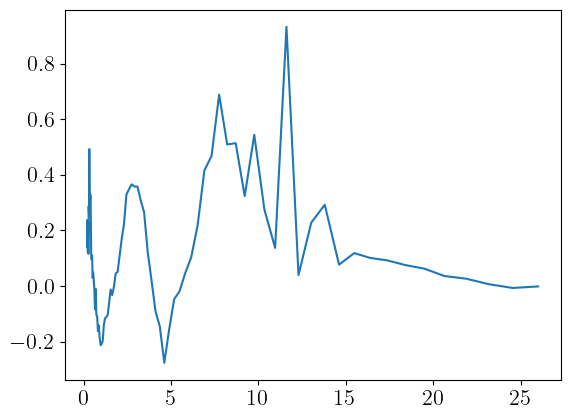

In [25]:
plt.plot(lc_plotter.t_best_fit, lc_plotter.best_fit_lc["bessellv"] - np.interp(lc_plotter.t_best_fit, true_lc[0], true_lc[1]["bessellv"]))